# Predicting the audusd rates

## Project structure


<img src="./pipeline.jpg" alt="Pipeline" width="800"/>

## Data acquisition


### Importing some libraries here

In [1]:
import yfinance as yf   
import pandas as pd
import numpy as np
from fredapi import Fred
import datetime as dt
from urllib.parse import urlparse
import os
import matplotlib.pyplot as plt
from data_processor import DataProcessor
from models import ArimaModel, CNNModel, LSTMModel
from helper import *
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend, optimizers
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv1D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
import warnings
warnings.filterwarnings("ignore")


### Identifying key factors and starting to collect...

In [2]:
# Ticker symbols mapping
# key: Yahoo Finance ticker symbol
# value: data frame column name
# 'USDJPY=X': 'usdjpy', 'USDCNY=X': 'usdcny', 'BTC-USD': 'btc',

ticker_dict = {
        'AUDUSD=X': 'audusd',
        'TIO=F': 'iron_ore',
        'GC=F': 'gold',
        '^VIX': 'vix',
    }
rates_dict = {
    'FEDFUNDS': 'fed_rates',
    'FPCPITOTLZGAUS': 'cpi',
    'FPCPITOTLZGUSA': 'us_cpi',
    'RBA': 'rba_rates',
}

In [3]:
data_file = f"./data.parquet"


# Check if data file exists and is recent (e.g., less than 1 hour old)
if os.path.exists(data_file):
    file_age = dt.datetime.now() - dt.datetime.fromtimestamp(os.path.getmtime(data_file))
    
    if file_age < dt.timedelta(hours=1):  # Data is fresh
        print(f"Loading existing data from {data_file} (age: {file_age})")
        df = pd.read_parquet(data_file)
        df = df.ffill().bfill()  # Fill missing values
    else:
        print("Data file is outdated, downloading fresh data...")
        df = download_and_process(ticker_dict=ticker_dict, data_file=data_file)
else:
    print("No existing data file found, downloading...")
    df = download_and_process(ticker_dict=ticker_dict, data_file=data_file)

print(df.tail())

Loading existing data from ./data.parquet (age: 0:32:23.577661)
                       audusd         gold    vix     sma_5    sma_10  \
date                                                                    
2025-08-14 15:00:00  0.649030  3388.899902  15.01  0.650409  0.651781   
2025-08-14 16:00:00  0.648959  3380.300049  14.91  0.649683  0.651295   
2025-08-14 17:00:00  0.649418  3383.800049  14.88  0.649423  0.650899   
2025-08-14 18:00:00  0.649650  3384.600098  14.77  0.649481  0.650591   
2025-08-14 19:00:00  0.650060  3385.899902  14.71  0.649423  0.650301   

                        ema_5    ema_10  momentum_5  momentum_10     std_5  \
date                                                                         
2025-08-14 15:00:00  0.650336  0.651501   -0.003848    -0.006050  0.001401   
2025-08-14 16:00:00  0.649877  0.651039   -0.003629    -0.004863  0.000802   
2025-08-14 17:00:00  0.649724  0.650744   -0.001302    -0.003959  0.000554   
2025-08-14 18:00:00  0.649699  0.6

## ARIMA Model

Starting walk-forward validation with 50 test points...
Walk-forward validation completed in 9.54 seconds
Test RMSE: 0.000667


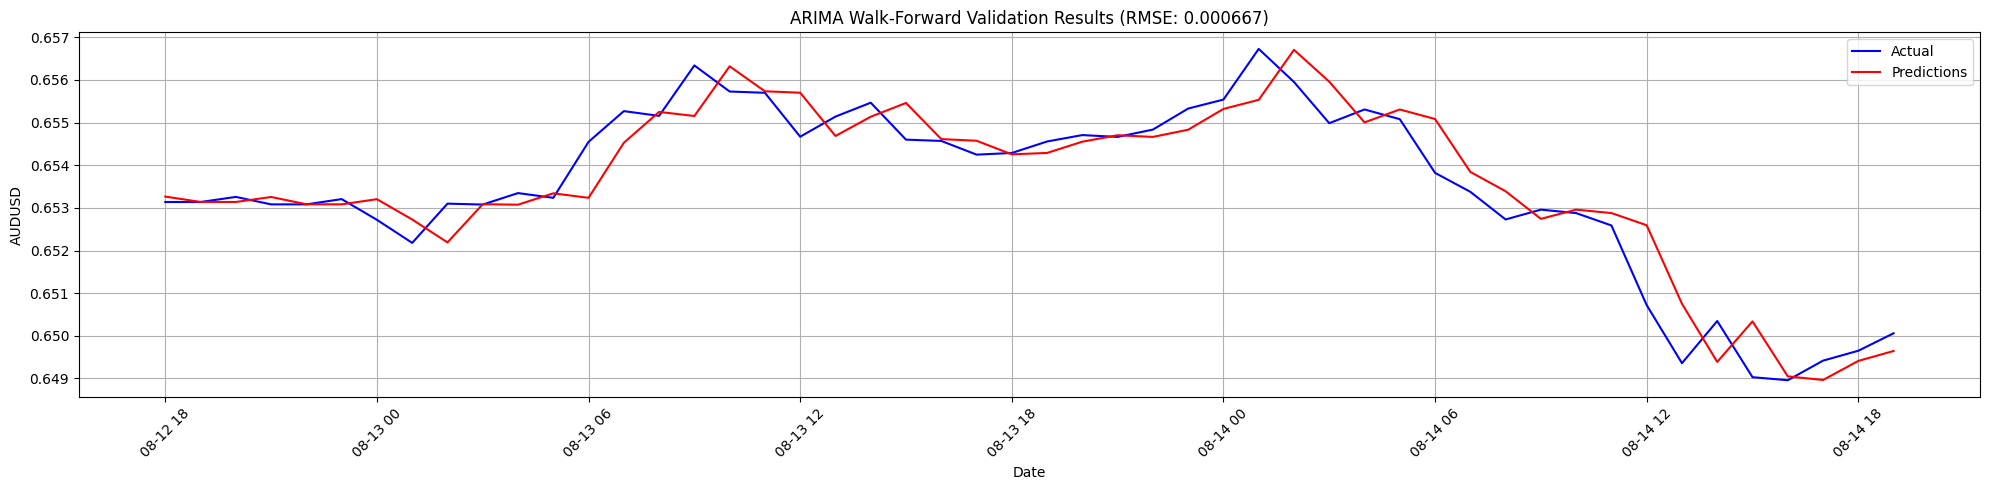

In [4]:
# Create ARIMA model instance
arima_model = ArimaModel(data=df, order=(1, 1, 1), target_col='audusd')

# Define exogenous variables (optional)
exog_vars = ['rates', 'fed_rates', 'iron_ore', 'gold', 'vix', 'cpi', 'us_cpi']

# Perform walk-forward validation
predictions, test, rmse = arima_model.walk_forward_validation(
    test_size=50, 
    order=(1, 1, 1),
    verbose=False
)

# Plot results
arima_model.plot_forecast_results(figsize=(20, 5))

In [5]:
test_stationarity(df['audusd'])

ADF Statistic: -2.1000310562660007
p-value: 0.24450211380429016
Critical Values:
  1%: -3.4318727392944743
  5%: -2.862212861882041
  10%: -2.5671281693534773
The time series is non-stationary


np.False_

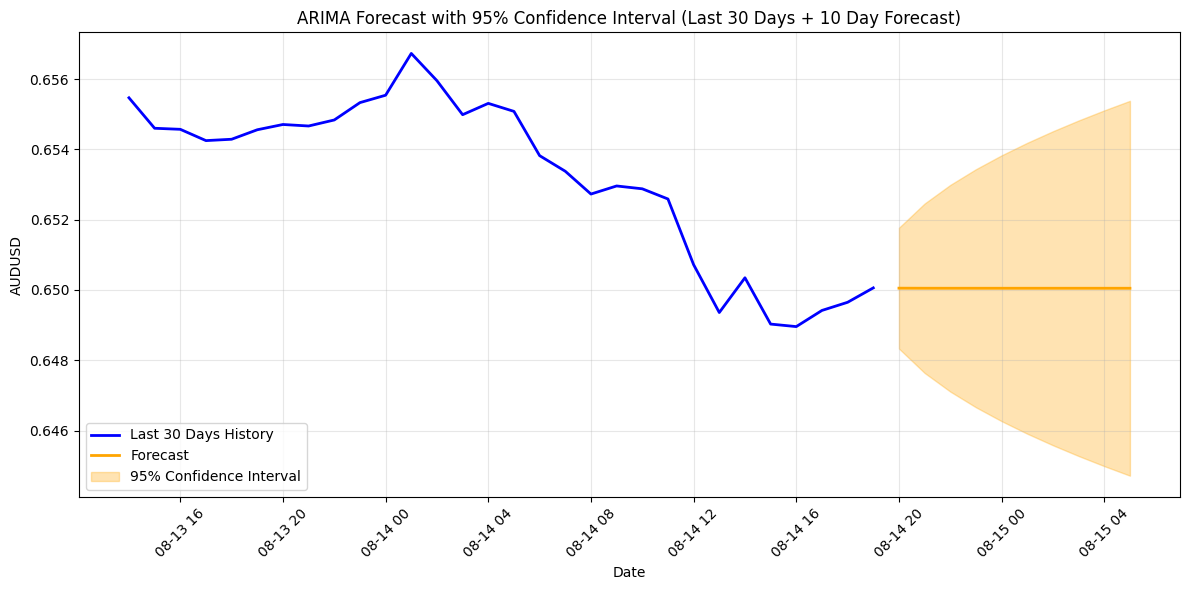

Forecast Summary for next 10 periods:
----------------------------------------------------------------------
2025-08-14: 0.650052 (95% CI: 0.648333 - 0.651770)
2025-08-14: 0.650050 (95% CI: 0.647640 - 0.652460)
2025-08-14: 0.650049 (95% CI: 0.647110 - 0.652989)
2025-08-14: 0.650049 (95% CI: 0.646663 - 0.653436)
2025-08-15: 0.650049 (95% CI: 0.646269 - 0.653830)
2025-08-15: 0.650049 (95% CI: 0.645912 - 0.654187)
2025-08-15: 0.650049 (95% CI: 0.645583 - 0.654516)
2025-08-15: 0.650049 (95% CI: 0.645277 - 0.654821)
2025-08-15: 0.650049 (95% CI: 0.644990 - 0.655109)
2025-08-15: 0.650049 (95% CI: 0.644718 - 0.655381)


In [ ]:
# First, we need to fit a model on the full dataset for forecasting
forecast_model = ArimaModel(data=df, order=(1, 1, 1), target_col='audusd')
forecast_model.fit()

# Generate forecasts with confidence intervals
mean_forecast, conf_int, history_data = forecast_model.forecast_with_confidence(
    forecast_horizon=10,
    history_window=30,
    figsize=(12, 6)
)

## CNN Model

In [45]:
# Create CNN model instance
cnn_model = CNNModel(data=df, target_col='audusd', train_ratio=0.80)

# Train the model with default parameters
cnn_model.fit(
    seq_len=20, 
    forecast_horizon=30, 
    epochs=2048, 
    batch_size=256, 
    validation_split=0.2, 
    patience=50, 
    verbose=1
)

=== Starting CNN Model Training Pipeline ===
1. Preparing data...
seq_len=20, forecast_horizon=30
Train size: 3452, Test size: 864
Shapes -> train_x: (3403, 20, 16) train_y: (3403, 30) y0_train: (3403, 30)
Shapes -> test_x: (815, 20, 16) test_y: (815, 30) y0_test: (815, 30)
2. Building model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        20,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │           990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,174 (102.24 KB)

 Trainable params: 26,174 (102.24 KB)

 Non-trainable params: 0 (0.00 B)

3. Training model...
Epoch 1/2048
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2782 - mae: 0.3546 - val_loss: 0.1366 - val_mae: 0.2478
Epoch 2/2048
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2646 - mae: 0.3441 - val_loss: 0.1293 - val_mae: 0.2392
Epoch 3/2048
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2555 - mae: 0.3372 - val_loss: 0.1285 - val_mae: 0.2366
Epoch 4/2048
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2475 - mae: 0.3312 - val_loss: 0.1214 - val_mae: 0.2291
Epoch 5/2048
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2354 - mae: 0.3218 - val_loss: 0.1105 - val_mae: 0.2183
Epoch 6/2048
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2156 - mae: 0.3077 - val_loss: 0.1034 - val_mae: 0.2106
Epoch 7/2048
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2075 - mae: 0.3002 - val_loss: 0.0964 - val_mae: 0.2034
Epoch 8/2048
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1930 - mae: 0.2902 - val_loss: 0.0922 - val_mae: 0.1991
Epoch 9/2048
11/11 ━━━━━━━━━━━━━━

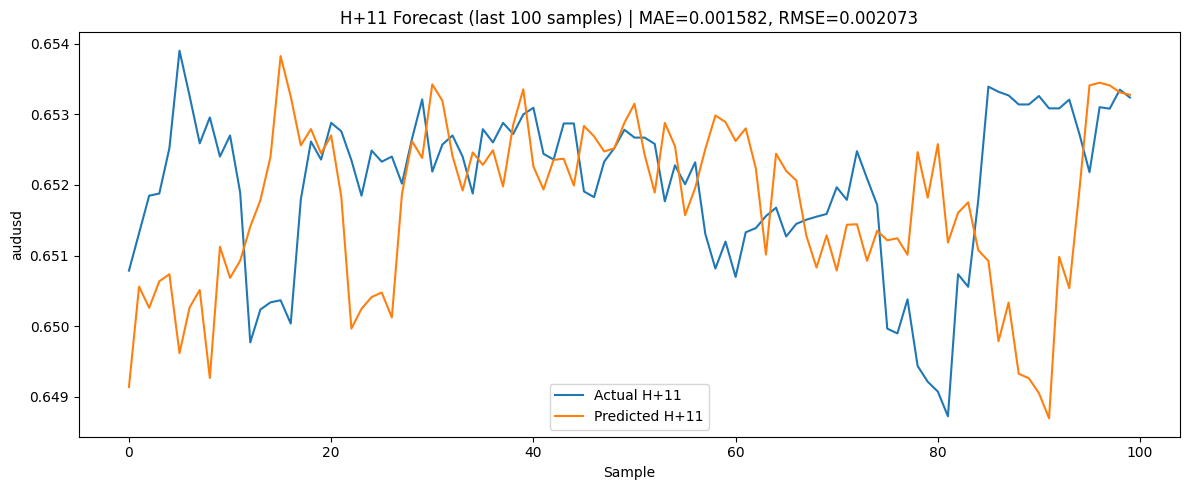

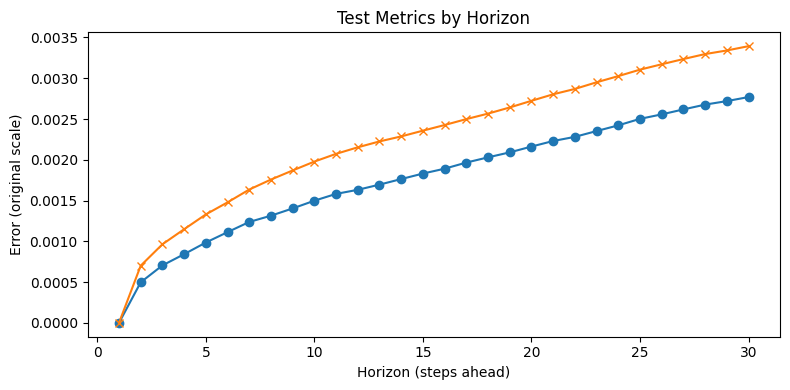

RMSE for H+1: 0.000001
MAE for H+1: 0.000000
RMSE for H+11: 0.002073
MAE for H+11: 0.001582


In [46]:
# Plot results using the CNNModel class methods

# Plot predictions for horizon H+11 (index 10)
cnn_model.plot_results(N=100, horizon=10)

# Plot MAE by horizon
cnn_model.plot_metrics_by_horizon()

# Get specific metrics
print(f"RMSE for H+1: {cnn_model.get_rmse(0):.6f}")
print(f"MAE for H+1: {cnn_model.get_mae(0):.6f}")
print(f"RMSE for H+11: {cnn_model.get_rmse(10):.6f}")
print(f"MAE for H+11: {cnn_model.get_mae(10):.6f}")

- We can also predict with a 95% confidence interval, using Monte Carlo Dropout.

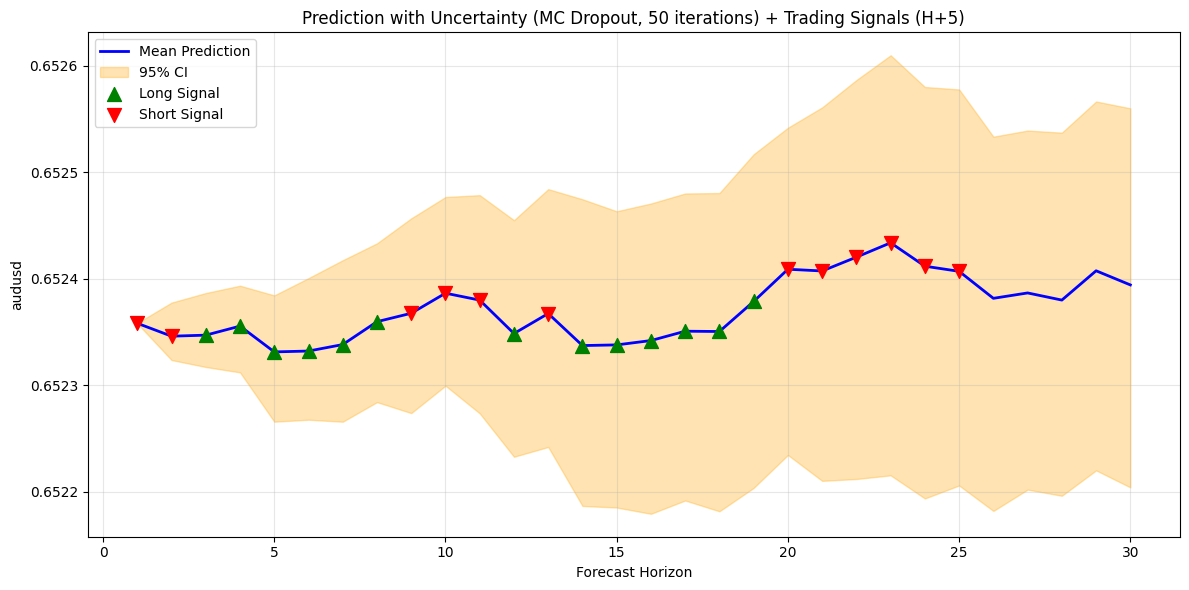

In [47]:
mean_pred, lower, upper, signals_df = cnn_model.predict_with_uncertainty(signal=True)

## Feature Selection before training

In [48]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# Features and target
feature_cols = [col for col in df.columns if col != 'audusd']
X = df[feature_cols].values
y = df['audusd'].values  # 1-step return

# Fit Random Forest
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Select top features (e.g., top 15)
top_features = importance_df['feature'].iloc[:15].tolist()
print("Selected features:", top_features)


Selected features: ['ema_5', 'sma_5', 'momentum_5', 'momentum_10', 'std_5', 'vix', 'rsi_14', 'gold', 'std_10', 'sma_10', 'ema_10', 'rates', 'fed_rates', 'cpi', 'us_cpi']


In [49]:

X_selected = pd.concat([df['audusd'], df[top_features]], axis=1)  # Select top features
X_selected

,audusd,ema_5,sma_5,momentum_5,momentum_10,std_5,vix,rsi_14,gold,std_10,sma_10,ema_10,rates,fed_rates,cpi,us_cpi
date,,,,,,,,,,,,,,,,
2024-12-06 00:00:00,0.644147,0.644147,0.643293,-0.000808,-0.001907,0.000646,13.63,37.151781,2684.100098,0.000506,0.643112,0.644147,4.35,4.48,3.161614,2.949525
2024-12-06 01:00:00,0.642438,0.643578,0.643293,-0.000808,-0.001907,0.000646,13.63,37.151781,2684.100098,0.000506,0.643112,0.643837,4.35,4.48,3.161614,2.949525
2024-12-06 02:00:00,0.643186,0.643447,0.643293,-0.000808,-0.001907,0.000646,13.63,37.151781,2684.100098,0.000506,0.643112,0.643718,4.35,4.48,3.161614,2.949525
2024-12-06 03:00:00,0.643658,0.643517,0.643293,-0.000808,-0.001907,0.000646,13.63,37.151781,2684.100098,0.000506,0.643112,0.643707,4.35,4.48,3.161614,2.949525
2024-12-06 04:00:00,0.643037,0.643357,0.643293,-0.000808,-0.001907,0.000646,13.63,37.151781,2684.100098,0.000506,0.643112,0.643585,4.35,4.48,3.161614,2.949525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-14 15:00:00,0.649030,0.650336,0.650409,-0.003848,-0.006050,0.001401,15.01,14.290533,3388.899902,0.001747,0.651781,0.651501,3.60,4.33,3.161614,2.949525
2025-08-14 16:00:00,0.648959,0.649877,0.649683,-0.003629,-0.004863,0.000802,14.91,15.288953,3380.300049,0.001792,0.651295,0.651039,3.60,4.33,3.161614,2.949525
2025-08-14 17:00:00,0.649418,0.649724,0.649423,-0.001302,-0.003959,0.000554,14.88,20.901111,3383.800049,0.001717,0.650899,0.650744,3.60,4.33,3.161614,2.949525


In [50]:
# Create CNN model instance
cnn_model2 = CNNModel(data=X_selected, target_col='audusd', train_ratio=0.80)

# Train the model with default parameters
cnn_model2.fit(
    seq_len=20, 
    forecast_horizon=30, 
    epochs=2048, 
    batch_size=256, 
    validation_split=0.2, 
    patience=50, 
    verbose=1
)

=== Starting CNN Model Training Pipeline ===
1. Preparing data...
seq_len=20, forecast_horizon=30
Train size: 3452, Test size: 864
Shapes -> train_x: (3403, 20, 16) train_y: (3403, 30) y0_train: (3403, 30)
Shapes -> test_x: (815, 20, 16) test_y: (815, 30) y0_test: (815, 30)
2. Building model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        20,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │           990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,174 (102.24 KB)

 Trainable params: 26,174 (102.24 KB)

 Non-trainable params: 0 (0.00 B)

3. Training model...
Epoch 1/2048
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3087 - mae: 0.3668 - val_loss: 0.1525 - val_mae: 0.2555
Epoch 2/2048
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2995 - mae: 0.3593 - val_loss: 0.1444 - val_mae: 0.2478
Epoch 3/2048
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2867 - mae: 0.3501 - val_loss: 0.1381 - val_mae: 0.2423
Epoch 4/2048
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2715 - mae: 0.3408 - val_loss: 0.1299 - val_mae: 0.2352
Epoch 5/2048
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2587 - mae: 0.3331 - val_loss: 0.1234 - val_mae: 0.2306
Epoch 6/2048
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2426 - mae: 0.3242 - val_loss: 0.1144 - val_mae: 0.2227
Epoch 7/2048
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2301 - mae: 0.3144 - val_loss: 0.1101 - val_mae: 0.2170
Epoch 8/2048
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2192 - mae: 0.3065 - val_loss: 0.1047 - val_mae: 0.2112
Epoch 9/2048
11/11 ━━━━━━━━━━━━━━━

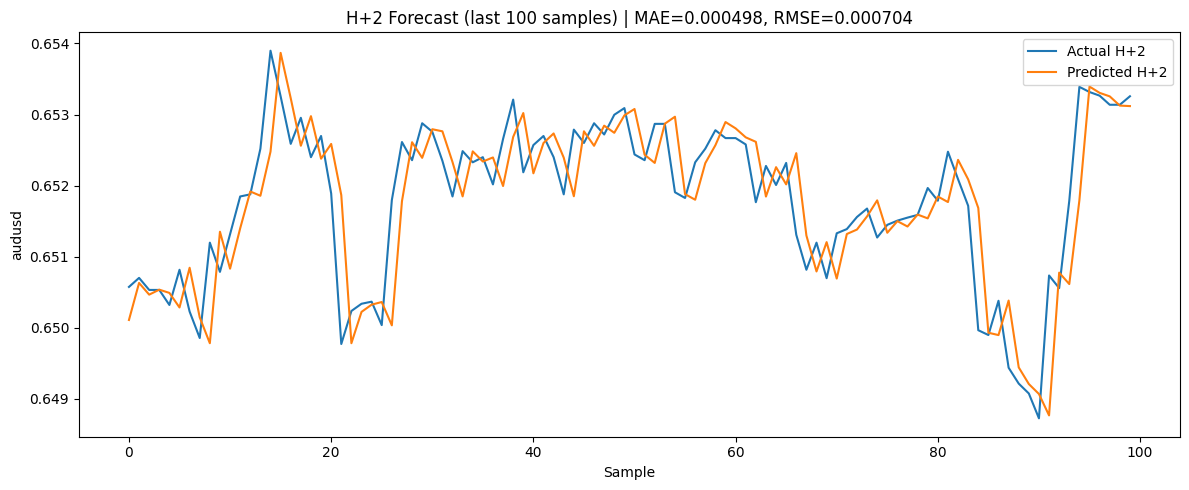

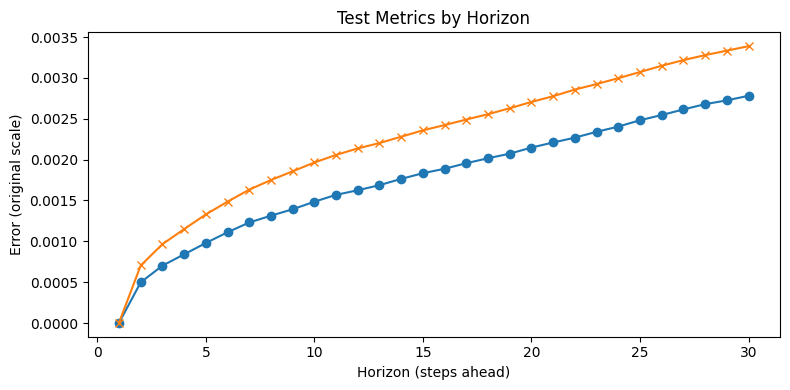

RMSE for H+1: 0.000004
MAE for H+1: 0.000002
RMSE for H+11: 0.002058
MAE for H+11: 0.001569


In [51]:
# Plot results using the CNNModel class methods

# Plot predictions for horizon H+11 (index 10)
cnn_model2.plot_results(N=100, horizon=1)

# Plot MAE by horizon
cnn_model2.plot_metrics_by_horizon()

# Get specific metrics
print(f"RMSE for H+1: {cnn_model2.get_rmse(0):.6f}")
print(f"MAE for H+1: {cnn_model2.get_mae(0):.6f}")
print(f"RMSE for H+11: {cnn_model2.get_rmse(10):.6f}")
print(f"MAE for H+11: {cnn_model2.get_mae(10):.6f}")

# Sentiment Analysis

## Scraping Reddit r/forex for submissions/comments regarding AUDUSD [Go to top](#data-acquisition)
- generous api allowance by Reddit
- potential to add other reliable news sources
- see demo_redditscraper.ipynb to experiment

Starting Full Sentiment Analysis Pipeline
Loading FinTwitBERT sentiment model...


Device set to use mps:1


Model setup complete!
Setting up dataset from /Users/lsd/Downloads/audusd_sentiment_pipeline/datasets/audusd
Directory /Users/lsd/Downloads/audusd_sentiment_pipeline/datasets/audusd already exists, skipping extraction.
Dataset ready with 3222 samples
Running sentiment prediction...


100%|██████████| 101/101 [00:38<00:00,  2.62it/s]

Sentiment prediction complete! Processed 3222 samples
Organizing data into DataFrame...
Data organized! DataFrame shape: (3222, 3)
Calculating sentiment scores...
Sentiment scores calculated! Daily data shape: (4100, 7)
Sentiment Analysis Complete!
Total samples processed: 3222
Date range: 2014-05-23 09:31:30+00:00 to 2025-08-12 05:24:28+00:00
Average daily sentiment: -0.033

Summary Statistics:
total_samples: 3222
date_range: (Timestamp('2014-05-23 09:31:30+0000', tz='UTC'), Timestamp('2025-08-12 05:24:28+0000', tz='UTC'))
avg_daily_sentiment: -0.033211547991474126
sentiment_std: 0.2063259981005642
avg_daily_comments: 0.7858536585365854
total_days: 4100
positive_days: 122
negative_days: 311
neutral_days: 3667


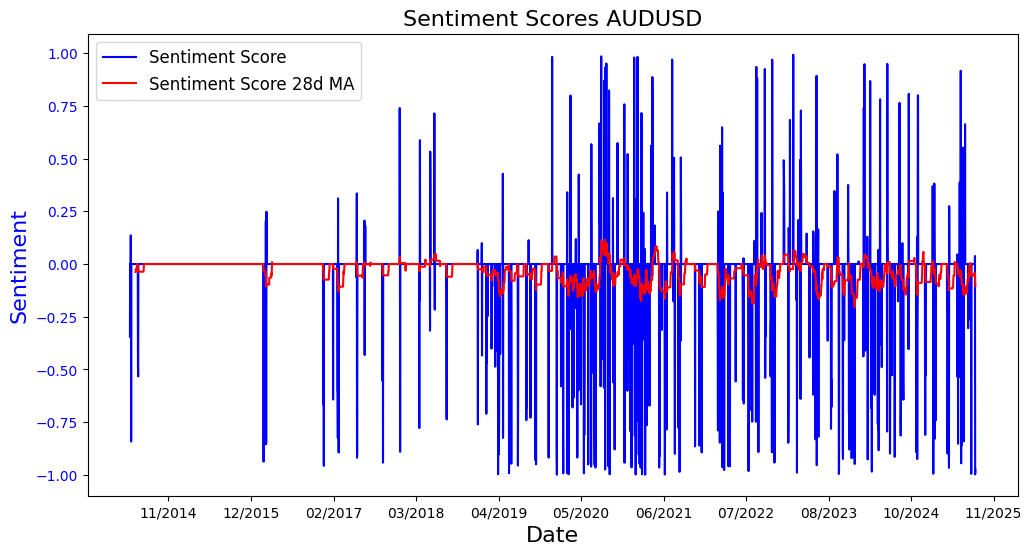

In [ ]:
from sentiment import *
# Initialize the sentiment analyzer
sentiment_analyzer = Sentiment(
    root_data_dir="/Users/lsd/Downloads/audusd_sentiment_pipeline/datasets",
    code="audusd",
    device=1  # Use GPU
)

# Run the complete analysis pipeline
senti, senti_daily = sentiment_analyzer.run_full_analysis(batch_size=32, window=28)

# Get summary statistics
stats = sentiment_analyzer.get_summary_stats()
# print("\nSummary Statistics:")
# for key, value in stats.items():
#     print(f"{key}: {value}")

# Plot the results
sentiment_analyzer.plot_sentiment()

In [53]:
senti_daily.index = senti_daily.index.date  # Convert index to date only
senti_daily.index.name = 'date'

In [54]:
df_senti = senti.copy()  # Create a copy of the sentiment DataFrame
df_senti.index = pd.to_datetime(df_senti.index).map(lambda x: x.replace(minute=0, second=0, microsecond=0)).tz_localize(None)

In [55]:
data = df.copy()  # Create a copy of the original dataframe


In [56]:
data.index = pd.to_datetime(data.index).map(lambda x: x.replace(minute=0, second=0, microsecond=0)).tz_localize(None)
df_senti.index = pd.to_datetime(df_senti.index).map(lambda x: x.replace(minute=0, second=0, microsecond=0)).tz_localize(None)
merged = data.join(df_senti, how='left', rsuffix='_senti')  # Join on index



# filling missing values this way is WRONG
# but we can do better with interpolation, given that we have sparse data
merged = merged.interpolate(method='time').ffill().bfill()  # Fill missing values

In [57]:
merged.head()

,audusd,gold,vix,sma_5,sma_10,ema_5,ema_10,momentum_5,momentum_10,std_5,std_10,rsi_14,rates,fed_rates,cpi,us_cpi,positive,neutral,negative,score
date,,,,,,,,,,,,,,,,,,,,
2024-12-06 00:00:00,0.644147,2684.100098,13.63,0.643293,0.643112,0.644147,0.644147,-0.000808,-0.001907,0.000646,0.000506,37.151781,4.35,4.48,3.161614,2.949525,0.205704,0.031409,0.762887,-0.575252
2024-12-06 01:00:00,0.642438,2684.100098,13.63,0.643293,0.643112,0.643578,0.643837,-0.000808,-0.001907,0.000646,0.000506,37.151781,4.35,4.48,3.161614,2.949525,0.205704,0.031409,0.762887,-0.575252
2024-12-06 02:00:00,0.643186,2684.100098,13.63,0.643293,0.643112,0.643447,0.643718,-0.000808,-0.001907,0.000646,0.000506,37.151781,4.35,4.48,3.161614,2.949525,0.205704,0.031409,0.762887,-0.575252
2024-12-06 03:00:00,0.643658,2684.100098,13.63,0.643293,0.643112,0.643517,0.643707,-0.000808,-0.001907,0.000646,0.000506,37.151781,4.35,4.48,3.161614,2.949525,0.205704,0.031409,0.762887,-0.575252
2024-12-06 04:00:00,0.643037,2684.100098,13.63,0.643293,0.643112,0.643357,0.643585,-0.000808,-0.001907,0.000646,0.000506,37.151781,4.35,4.48,3.161614,2.949525,0.205704,0.031409,0.762887,-0.575252


In [58]:
# Create CNN model instance
cnn_model1 = CNNModel(data=merged, target_col='audusd', train_ratio=0.80)

# Train the model with default parameters
cnn_model1.fit(
    seq_len=32, 
    forecast_horizon=30, 
    epochs=2048, 
    batch_size=128, 
    validation_split=0.2, 
    patience=30, 
    verbose=1
)

=== Starting CNN Model Training Pipeline ===
1. Preparing data...
seq_len=32, forecast_horizon=30
Train size: 3599, Test size: 900
Shapes -> train_x: (3538, 32, 20) train_y: (3538, 30) y0_train: (3538, 30)
Shapes -> test_x: (839, 32, 20) test_y: (839, 30) y0_test: (839, 30)
2. Building model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 32, 32)         │         1,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 32, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │           990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,846 (151.74 KB)

 Trainable params: 38,846 (151.74 KB)

 Non-trainable params: 0 (0.00 B)

3. Training model...
Epoch 1/2048
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3386 - mae: 0.3979 - val_loss: 0.2161 - val_mae: 0.3287
Epoch 2/2048
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3068 - mae: 0.3771 - val_loss: 0.1924 - val_mae: 0.3080
Epoch 3/2048
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2854 - mae: 0.3630 - val_loss: 0.1712 - val_mae: 0.2887
Epoch 4/2048
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2550 - mae: 0.3421 - val_loss: 0.1542 - val_mae: 0.2736
Epoch 5/2048
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2302 - mae: 0.3240 - val_loss: 0.1435 - val_mae: 0.2618
Epoch 6/2048
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2125 - mae: 0.3119 - val_loss: 0.1288 - val_mae: 0.2497
Epoch 7/2048
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1866 - mae: 0.2905 - val_loss: 0.1109 - val_mae: 0.2330
Epoch 8/2048
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1686 - mae: 0.2754 - val_loss: 0.1025 - val_mae: 0.2229
Epoch 9/2048
23/23 ━━━━━━━━━━━━━━━━

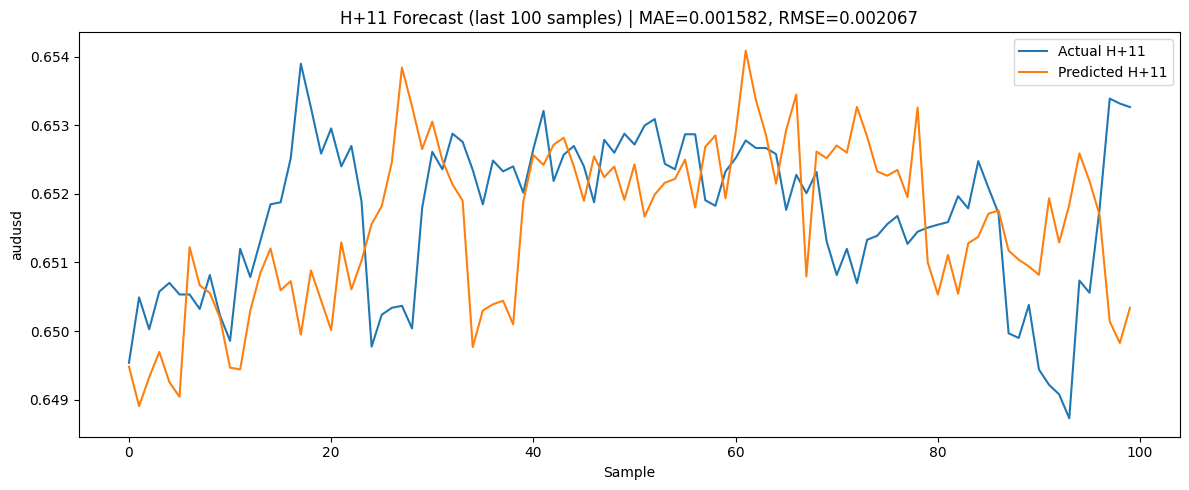

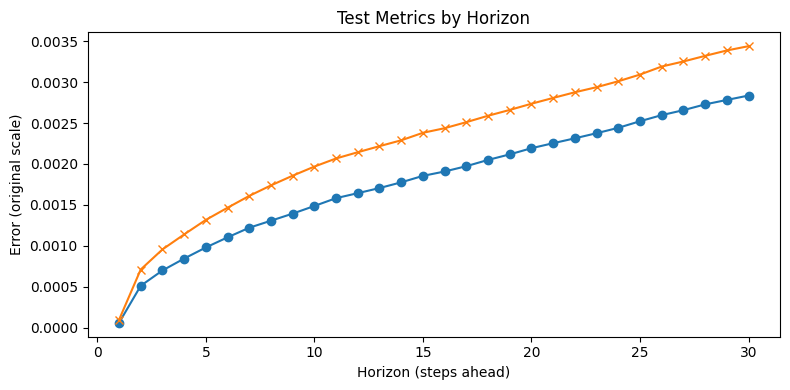

In [59]:
# Plot results using the CNNModel class methods

# Plot predictions for horizon H+11 (index 10)
cnn_model1.plot_results(N=100, horizon=10)

# Plot MAE by horizon
cnn_model1.plot_metrics_by_horizon()



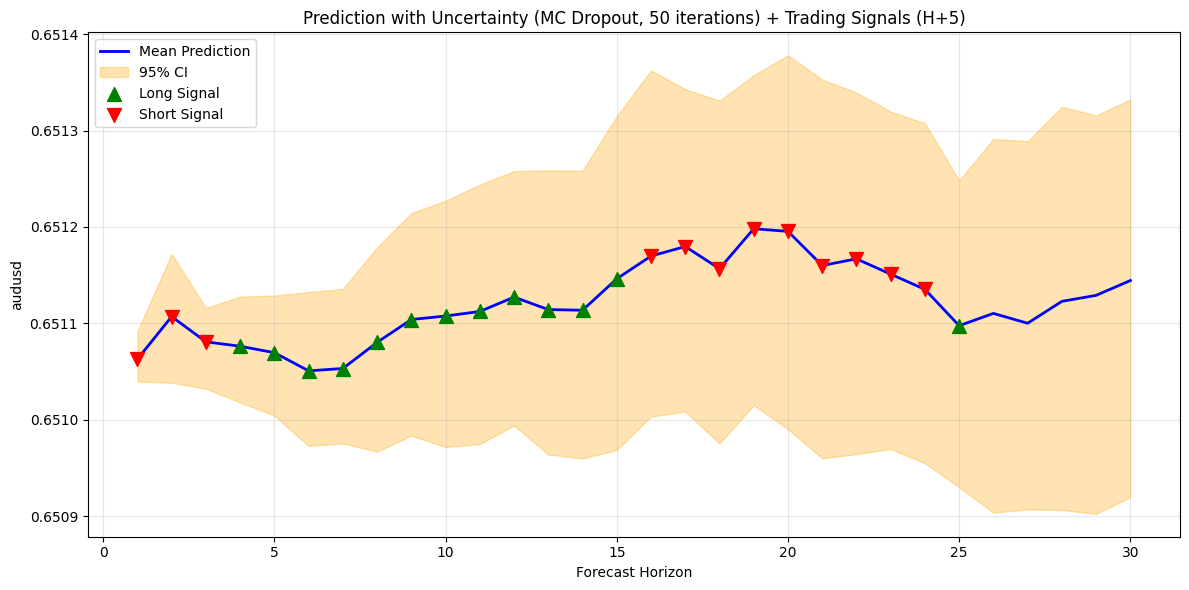

In [60]:
_, _, _, _ = cnn_model1.predict_with_uncertainty(signal=True)

## Work and future work

- [x] Multi-Step forecasts with confidence intervals and trading signals, using CNN model;
- [x] Sentiment anlaysis using Reddit r/forex comments and sentiment score as a predictive variable;
- [  ] Look into if model is memorizing instead learning;
- [  ] Add backtesting, using predicted signals; 
- [  ] Automatically partial fit the model when new data comes in, every 2h/1d;

# Acknowledgements

Thanks to Richard, Mitchell, Copilot, @LukeDitria, and everyone for listening.